Ce notebook vise à traiter les indices de secheresse SPEI pour la visualisation, la spatialisation. Nous y avons categorisé les types de secheresses (Extreme, Severe, ...), puis labelisé.

#### Importation des librairies

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.signal import filtfilt
import pandas as pd
from scipy.stats import genlogistic
import matplotlib.pyplot as plt
from scipy import stats
from config import Config, Constant
import warnings
warnings.filterwarnings('ignore')

#### Transposition de dataframe

In [2]:
def transposition_data(data, parametre):
    data_trans =data.melt(id_vars=['Date'], value_vars= data.columns[1:],var_name='Station',value_name=parametre)
    return data_trans

#### Changement de label de categorie de secheresse

In [3]:
def replace_text_with_one(data_df, target_text):
    dataframe = data_df.copy()    
    def replace_labels(value):
        if pd.notna(value) and value == target_text:
            return '1'
        elif pd.notna(value):
            return '0'
        else:
            return value  # Garder les valeurs manquantes telles quelles    
    # Appliquer la fonction à la colonne 'Label Secheresse' en utilisant une fonction lambda
    dataframe['Label Secheresse'] = dataframe['Label Secheresse'].apply(lambda x: replace_labels(x))    
    return dataframe

#### Categorisation de la secheresse

In [4]:

# Définition de la fonction de catégorisation
def categorize_spei(spei_value):
    if np.isnan(spei_value):
        return np.nan  # Laisser les valeurs manquantes inchangées
    if spei_value >= 2.0:
        return Constant.LABEL_1   #"Extrêmement humide"
    elif 1.5 <= spei_value < 2.0:
        return Constant.LABEL_2   #"Très humide"
    elif 1.0 <= spei_value < 1.5:
        return Constant.LABEL_3   #"Modérément humide"
    elif -0.99 <= spei_value <= 0.99:
        return Constant.LABEL_4   #"Normal"
    elif -1.49 <= spei_value < -1.0:
        return Constant.LABEL_5   #"Sécheresse modérée"
    elif -1.99 <= spei_value < -1.5:
        return Constant.LABEL_6   #"Sécheresse sévère"
    else:
        return Constant.LABEL_7   #"Sécheresse extrême"

def categorize_drought(df):
    new_df = df.copy()
    new_df.iloc[:, 1:] = new_df.iloc[:, 1:].applymap(categorize_spei)
    return new_df        

#### Graphiques pour SPEI

In [5]:
def plot_spei_for_stations(data_df, freq='M'):
    # Créer une copie du DataFrame
    dataframe = data_df.copy()
    # Convertir la colonne 'Date' en un format de date
    if freq == 'M':
        date_format = '%Y%m'
    elif freq == 'D':
        date_format = '%Y%m%d'
    else:
        raise ValueError("La valeur de 'freq' doit être 'M' (mensuel) ou 'D' (décadaire)")
    
    dataframe['Date'] = pd.to_datetime(dataframe['Date'], format=date_format)
    
    # Redimensionner les dates pour représenter les premières décades si 'freq' est 'D'
    if freq == 'D':
        dataframe['Date'] = dataframe['Date'].dt.to_period('D').dt.start_time
    
    # Liste des noms de stations
    stations = dataframe.columns[1:]
    
    # Parcourir les stations et créer un graphe pour chaque station
    for station in stations:
        plt.figure(figsize=(10, 6))
        plt.plot(dataframe['Date'], dataframe[station], marker='o', linestyle='-')
        plt.title(f'Graphique SPEI pour la station {station}')
        plt.axhline(y=0, color='green', linestyle='--', label='Normal')
        plt.axhline(y=-2, color='red', linestyle='--', label='Extreme')
        plt.axhline(y=-1.5, color='blue', linestyle='--', label='Severe')
        plt.xlabel('Date')
        plt.ylabel('Valeur SPEI')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        # Sauvegarder le graphe dans un fichier
        #plt.savefig(f'graphe_spei_{station}.png')
        plt.show()

#### Visualisation avec zoom sur un type de secheresse

In [6]:
def process_and_plot_data(df_data, freq='M', *args):
    # Créer une copie du DataFrame
    dataframe = df_data.copy()
    # Convertir la colonne 'Date' en un format de date
    if freq == 'M':
        date_format = '%Y%m'
    elif freq == 'D':
        date_format = '%Y%m%d'
    else:
        raise ValueError("La valeur de 'freq' doit être 'M' (mensuel) ou 'D' (décadaire)")
    
    dataframe['Date'] = pd.to_datetime(dataframe['Date'], format=date_format)   
    # Définir la liste des colonnes de stations
    stations_columns = dataframe.columns[1:]
    for station in stations_columns:
        df_station = dataframe[['Date', station]].copy()
        if len(args) == 1:
            threshold = args[0]
            df_station[station] = df_station[station].apply(
                lambda x: threshold if x > threshold else x
            )
        elif len(args) == 2:
            lower_threshold, upper_threshold = args
            df_station[station] = df_station[station].apply(
                lambda x: lower_threshold if x < lower_threshold else upper_threshold if x > upper_threshold else x
            )
        # Tracer le graphe pour chaque station
        plt.figure(figsize=(10, 6))
        plt.plot(df_station['Date'], df_station[station])
        #plt.axhline(y=-2, color='r', linestyle='--', label='Threshold (-2)')
        plt.xlabel('Date')
        plt.ylabel('SPEI Value')
        plt.title(f'SPEI Values for {station}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Occurence des apparutions de secheresse extreme et severe

In [7]:
def calculate_secheresse_percentage(df, secheresse_label_1, secheresse_label_2):
    # Liste pour stocker les pourcentages pour les deux catégories
    pourcentages_1 = []
    pourcentages_2 = []
    dataframe=df.copy()

    # Parcours de chaque ligne du DataFrame
    for _, row in dataframe.iterrows():
        # Comptage du nombre de colonnes contenant la catégorie de sécheresse donnée
        count_secheresse_1 = row.drop('Date').astype(str).str.count(secheresse_label_1).sum()
        count_secheresse_2 = row.drop('Date').astype(str).str.count(secheresse_label_2).sum()

        # Comptage du nombre total de colonnes non manquantes (en excluant la colonne 'Date')
        total_non_missing = row.drop('Date').count()

        # Calcul du pourcentage en gérant les valeurs manquantes
        if total_non_missing > 0:
            pourcentage_1 = (count_secheresse_1 / total_non_missing) * 100
            pourcentage_2 = (count_secheresse_2 / total_non_missing) * 100
        else:
            pourcentage_1 = np.nan
            pourcentage_2 = np.nan

        pourcentages_1.append(pourcentage_1)
        pourcentages_2.append(pourcentage_2)

    # Ajout des listes de pourcentages comme nouvelles colonnes
    dataframe[f'Pourcentage {secheresse_label_1}'] = pourcentages_1
    dataframe[f'Pourcentage {secheresse_label_2}'] = pourcentages_2

    # Sélection des colonnes 'Date' et les deux dernières colonnes ajoutées
    selected_columns = ['Date', f'Pourcentage {secheresse_label_1}', f'Pourcentage {secheresse_label_2}']
    dataframe = dataframe[selected_columns]

    return dataframe

#### Visualisation de la secheresse spatiale

In [8]:
def plot_drought_percentages(df_data, spei, freq='M'):
    df = df_data.copy()

    # Convertir la colonne 'Date' en un format de date
    if freq == 'M':
        date_format = '%Y%m'
    elif freq == 'D':
        date_format = '%Y%m%d'
    else:
        raise ValueError("La valeur de 'freq' doit être 'M' (mensuel) ou 'D' (décadaire)")

    # Convertir la colonne 'Date' en format de date
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)

    # Trier le DataFrame par la colonne 'Date' si ce n'est pas déjà fait
    df = df.sort_values(by='Date')

    # Créer le graphe à barres
    plt.figure(figsize=(12, 6))  # Ajustez la taille de la figure selon vos besoins

    plt.bar(df['Date'], df['Pourcentage Sécheresse extrême'], width=15, label='Extrême', color='red', alpha=0.7)
    plt.bar(df['Date'], df['Pourcentage Sécheresse sévère'], width=15, label='Sévère', color='blue', alpha=0.7)
    plt.axhline(y=25, color='green', linestyle='--', label='')

    # Ajouter des étiquettes et des titres
    plt.xlabel('Date')
    plt.ylabel('Pourcentage')
    plt.title(f'{spei}: taux de Sécheresse Extrême et Sévère')
    plt.legend()

    # Personnaliser les étiquettes de l'axe x pour afficher toutes les quatre années
    plt.xticks(df['Date'][::60], df['Date'].dt.year[::60], rotation=45)

    # Afficher le graphe
    plt.tight_layout()  # Pour éviter que les étiquettes ne se chevauchent
    plt.show()


#### Visualisation de ECDF

In [9]:
def plot_ecdf(df_data,spei, freq='M'):
    
    df = df_data.copy()

    # Convertir la colonne 'Date' en un format de date
    if freq == 'M':
        date_format = '%Y%m'
    elif freq == 'D':
        date_format = '%Y%m%d'
    else:
        raise ValueError("La valeur de 'freq' doit être 'M' (mensuel) ou 'D' (décadaire)")
    
    # Convertir la colonne 'Date' en format de date
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    
    # Supprimer les lignes avec des valeurs NaN dans les colonnes pertinentes
    df_data.dropna(subset=['Pourcentage Sécheresse extrême', 'Pourcentage Sécheresse sévère'], inplace=True)

    # Trier le dataframe par date (au cas où il ne le serait pas déjà)
    df_data.sort_values(by='Date', inplace=True)

    # Extraire les données pour les deux colonnes
    data_extreme = df_data['Pourcentage Sécheresse extrême']
    data_severe = df_data['Pourcentage Sécheresse sévère']

    # Calculer l'ECDF pour les données
    x_extreme = np.sort(data_extreme)
    y_extreme = np.arange(1, len(x_extreme) + 1) / len(x_extreme)

    x_severe = np.sort(data_severe)
    y_severe = np.arange(1, len(x_severe) + 1) / len(x_severe)

    # Tracer les résultats dans un même graphique en utilisant plt.plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_extreme, y_extreme, label='Sécheresse extrême', linestyle='--')
    plt.plot(x_severe, y_severe, label='Sécheresse sévère', linestyle='-')
    plt.xlabel('Cohérence spatiale (%)')
    plt.ylabel('Probabilité Cumulative')
    plt.legend()
    plt.title(f'{spei}: ECDF des Pourcentages de Sécheresse')
    plt.grid(True)
    # Afficher le graphique
    plt.show()

In [10]:
# Définition de la fonction to_numeric_with_nan
def to_numeric_with_nan(value):
    try:
        return int(value)
    except (ValueError, TypeError):
        return pd.NA  # Retourne une valeur manquante

#### Saison des pluies

In [11]:
#Lecture du fichier des dates de pluies
saison_pluie=pd.read_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.STATION_ALL))
saison_pluie.sort_values(by=['Station', 'Year', 'Month','Decade','Day'], ascending=True, inplace=True)
#Saison des pluies mois
saison_pluie_mois=saison_pluie.drop_duplicates(subset=['Station', 'Year', 'Month'], keep='last')
saison_pluie_mois=saison_pluie_mois[['Station', 'Year', 'Month','Saison_Pluie']]
# Ajouter un zéro au début du mois si nécessaire et créer la colonne 'Date'
saison_pluie_mois['Date'] = saison_pluie_mois['Year'].astype(str) + saison_pluie_mois['Month'].apply(lambda x: str(x).zfill(2))
#Saison des pluies decades
saison_pluie_decade=saison_pluie.drop_duplicates(subset=['Station', 'Year', 'Month','Decade'], keep='last')
saison_pluie_decade=saison_pluie_decade[['Station', 'Year', 'Month','Decade','Saison_Pluie']]
# Ajouter un zéro au début du mois si nécessaire et créer la colonne 'Date'
saison_pluie_decade['Date'] = saison_pluie_decade['Year'].astype(str) + saison_pluie_decade['Month'].apply(lambda x: str(x).zfill(2))+ saison_pluie_decade['Decade'].apply(lambda x: str(x).zfill(2))
# Supprimer les colonnes 'Annee','Mois' et 'Decade'
#saison_pluie_decade.drop(columns=['Annee', 'Mois','Decade'], inplace=True)

In [12]:
saison_pluie_decade.head()

,Station,Year,Month,Decade,Saison_Pluie,Date
9,Bobo_Dioulasso,1961,1,1,False,19610101
19,Bobo_Dioulasso,1961,1,2,False,19610102
30,Bobo_Dioulasso,1961,1,3,False,19610103
40,Bobo_Dioulasso,1961,2,1,False,19610201
50,Bobo_Dioulasso,1961,2,2,False,19610202


#### Filtre de dataframes pour controle

In [13]:
def filter_data_by_year_station(dataframe, year, station):
    year_str = str(year)  # Convertir l'année en chaîne de caractères
    filtered_df = dataframe.loc[(dataframe['Date'].astype(str).str.startswith(year_str)) & (dataframe['Station'] == station)]
    return filtered_df

### I-SPEI DECADAIRE

#### I.1- Lecture des données de spei décadaires

In [14]:
# Lire les données de SPEI decadaires obtenu par CDT
spei_1dek=pd.read_csv(str(Config.SPEI_PATH) + '/' + str(Config.SPEI_1DEK_FILE_NAME),encoding='ISO-8859-1')
# Remplacer les valeurs manquantes (-9999) par NaN pour le tracé correct
spei_1dek = spei_1dek.replace(-9999, float('nan'))
#spei_1dek_categorized = categorize_severity(spei_1dek)
spei_1dek_categorized = categorize_drought(spei_1dek)

In [15]:
spei_1dek_categorized.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dori,Dedougou,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,1961011,Humidité sévère,NaN,Humidité sévère,Normale,Humidité modérée,Humidité sévère,Normale,Humidité extrême,Humidité sévère,NaN
1,1961012,Normale,NaN,Humidité modérée,Normale,Normale,Humidité extrême,Normale,Humidité modérée,Humidité extrême,NaN
2,1961013,Humidité modérée,NaN,Humidité extrême,Humidité modérée,Normale,Humidité modérée,Normale,Normale,Normale,NaN
3,1961021,Humidité extrême,NaN,Humidité sévère,Normale,Normale,Humidité extrême,Humidité modérée,Humidité sévère,Normale,NaN
4,1961022,Humidité sévère,NaN,Humidité sévère,Normale,Normale,Humidité sévère,Normale,Humidité modérée,Humidité modérée,NaN


#### I.2 - Graphes pour le SPEI decadaire

In [16]:
# Utilisation de la fonction avec votre DataFrame spei_1dek
#plot_spei_for_stations(spei_1dek, freq='D')

#### I.3- Secheresse spatiale

##### I.3.a - Calcul secheresse spatiale

In [17]:
spei_1dek_spatial = calculate_secheresse_percentage(spei_1dek_categorized, Constant.LABEL_7, Constant.LABEL_6)
# Affichage
spei_1dek_spatial.head()

,Date,Pourcentage Sécheresse extrême,Pourcentage Sécheresse sévère
0,1961011,0.0,0.0
1,1961012,0.0,0.0
2,1961013,0.0,0.0
3,1961021,0.0,0.0
4,1961022,0.0,0.0


In [18]:
# Trouvez l'indice de la ligne avec la valeur maximale dans 'Pourcentage Sécheresse extrême'
indice_ligne_max_secheresse_extreme = spei_1dek_spatial[f'Pourcentage {Constant.LABEL_7}'].idxmax()
# Obtenez la ligne correspondante à cet indice
ligne_max_secheresse_extreme = spei_1dek_spatial.loc[indice_ligne_max_secheresse_extreme]
# Maintenant, ligne_max_secheresse_extreme contient la ligne avec la plus haute valeur dans 'Pourcentage Sécheresse extrême'
print(ligne_max_secheresse_extreme)

Date                              1976103.0
Pourcentage Sécheresse extrême        100.0
Pourcentage Sécheresse sévère           0.0
Name: 569, dtype: float64


##### I.3.b - Visualisation secheresse spatiale

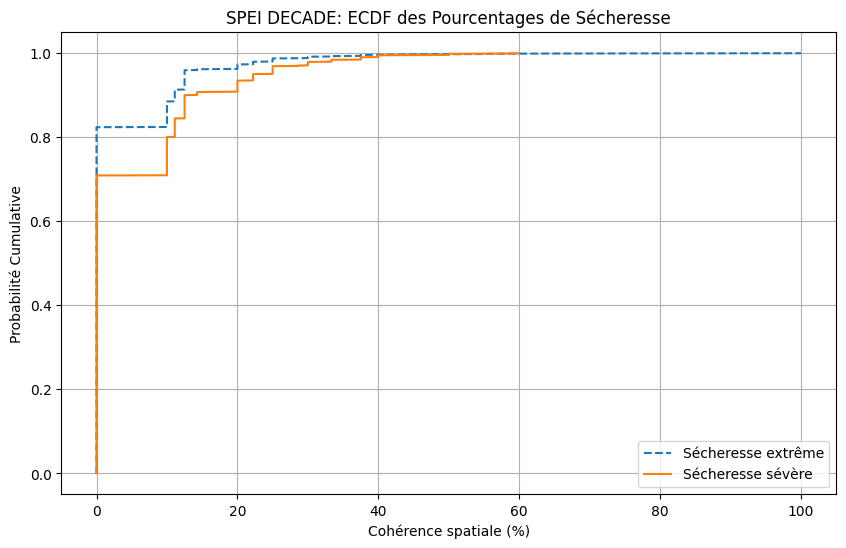

In [19]:
plot_ecdf(spei_1dek_spatial,'SPEI DECADE', freq='D')

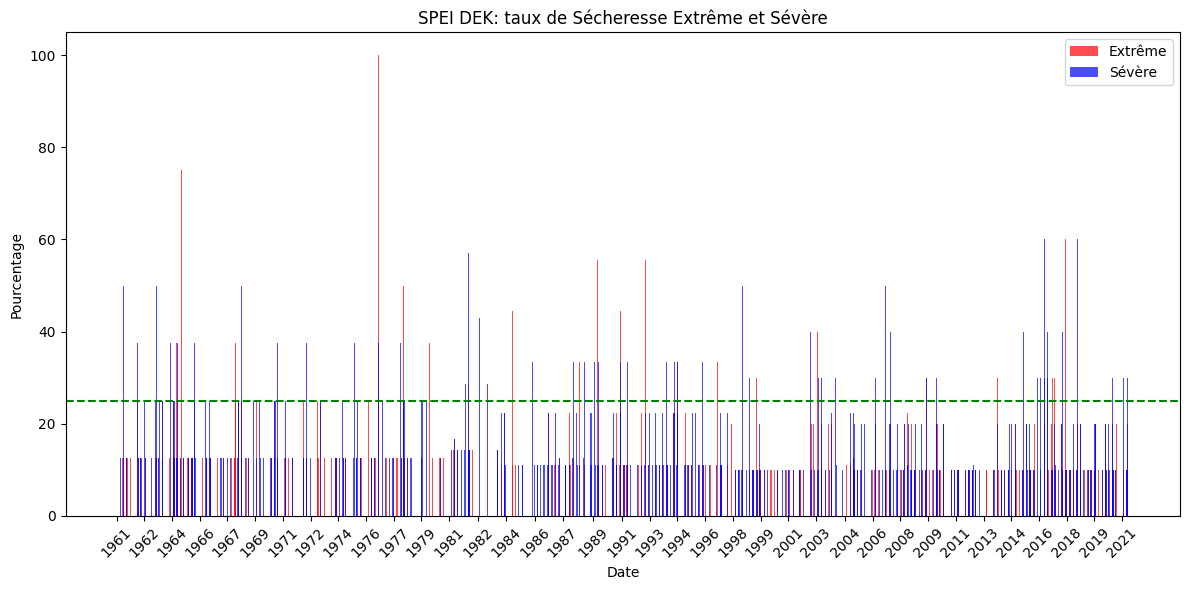

In [20]:
plot_drought_percentages(spei_1dek_spatial,'SPEI DEK',freq='D')

#### I.4- Label des secheresses

In [21]:
spei_1dek_saison=transposition_data(spei_1dek_categorized,'Label Secheresse')

In [22]:
spei_1dek_saison.head()

,Date,Station,Label Secheresse
0,1961011,Bobo_Dioulasso,Humidité sévère
1,1961012,Bobo_Dioulasso,Normale
2,1961013,Bobo_Dioulasso,Humidité modérée
3,1961021,Bobo_Dioulasso,Humidité extrême
4,1961022,Bobo_Dioulasso,Humidité sévère


In [23]:
saison_pluie_decade.head()

,Station,Year,Month,Decade,Saison_Pluie,Date
9,Bobo_Dioulasso,1961,1,1,False,19610101
19,Bobo_Dioulasso,1961,1,2,False,19610102
30,Bobo_Dioulasso,1961,1,3,False,19610103
40,Bobo_Dioulasso,1961,2,1,False,19610201
50,Bobo_Dioulasso,1961,2,2,False,19610202


In [24]:
import pandas as pd

# Définition de la fonction to_numeric_with_nan
def to_numeric_with_nan(value):
    try:
        return int(value)
    except (ValueError, TypeError):
        return pd.NA  # Retourne une valeur manquante

In [25]:
spei_1dek_saison['Date'] = pd.to_datetime(spei_1dek_saison['Date'], format='%Y%m%d')
saison_pluie_decade['Date'] = pd.to_datetime(saison_pluie_decade['Date'], format='%Y%m%d')
spei_1dek_fusion = pd.merge(spei_1dek_saison, saison_pluie_decade, on=['Date','Station'], how='outer')

In [26]:
spei_1dek_fusion[['Year', 'Month', 'Decade']] = spei_1dek_fusion[['Year', 'Month', 'Decade']].applymap(to_numeric_with_nan)


In [27]:
saison_pluie_decade.head()

,Station,Year,Month,Decade,Saison_Pluie,Date
9,Bobo_Dioulasso,1961,1,1,False,1961-01-01
19,Bobo_Dioulasso,1961,1,2,False,1961-01-02
30,Bobo_Dioulasso,1961,1,3,False,1961-01-03
40,Bobo_Dioulasso,1961,2,1,False,1961-02-01
50,Bobo_Dioulasso,1961,2,2,False,1961-02-02


In [28]:
spei_1dek_saison.head()

,Date,Station,Label Secheresse
0,1961-01-01,Bobo_Dioulasso,Humidité sévère
1,1961-01-02,Bobo_Dioulasso,Normale
2,1961-01-03,Bobo_Dioulasso,Humidité modérée
3,1961-02-01,Bobo_Dioulasso,Humidité extrême
4,1961-02-02,Bobo_Dioulasso,Humidité sévère


In [29]:
spei_1dek_fusion.head()

,Date,Station,Label Secheresse,Year,Month,Decade,Saison_Pluie
0,1961-01-01,Bobo_Dioulasso,Humidité sévère,1961,1,1,False
1,1961-01-02,Bobo_Dioulasso,Normale,1961,1,2,False
2,1961-01-03,Bobo_Dioulasso,Humidité modérée,1961,1,3,False
3,1961-02-01,Bobo_Dioulasso,Humidité extrême,1961,2,1,False
4,1961-02-02,Bobo_Dioulasso,Humidité sévère,1961,2,2,False


##### I.4.a- Secheresse extreme

In [30]:
spei_1dek_extreme = replace_text_with_one(spei_1dek_fusion, Constant.LABEL_7)

In [31]:
spei_1dek_extreme.to_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.DATA_1DEK_EXTR),index=False)

In [32]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_1dek_extreme, 1992, 'Bobo_Dioulasso')

In [33]:
filtered_Bobo_1992.head()

,Date,Station,Label Secheresse,Year,Month,Decade,Saison_Pluie
1116,1992-01-01,Bobo_Dioulasso,0,1992,1,1,False
1117,1992-01-02,Bobo_Dioulasso,0,1992,1,2,False
1118,1992-01-03,Bobo_Dioulasso,0,1992,1,3,False
1119,1992-02-01,Bobo_Dioulasso,0,1992,2,1,False
1120,1992-02-02,Bobo_Dioulasso,0,1992,2,2,False


##### Zoom sur la secheresse extreme

In [34]:
#process_and_plot_data(spei_1dek,'D',-2)
#process_and_plot_data(spei_1dek, 'D', Constant.SEUIL_4)

##### I.4.b- Secheresse severe

In [35]:
#spei_1dek_severe = replace_text_with_one(spei_1dek_fusion, 'Secheresse severe')
spei_1dek_severe = replace_text_with_one(spei_1dek_fusion, Constant.LABEL_6)

In [36]:
spei_1dek_severe.to_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.DATA_1DEK_SEV),index=False)

In [37]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_1dek_severe, 1992, 'Bobo_Dioulasso')

In [38]:
spei_1dek_severe.head()

,Date,Station,Label Secheresse,Year,Month,Decade,Saison_Pluie
0,1961-01-01,Bobo_Dioulasso,0,1961,1,1,False
1,1961-01-02,Bobo_Dioulasso,0,1961,1,2,False
2,1961-01-03,Bobo_Dioulasso,0,1961,1,3,False
3,1961-02-01,Bobo_Dioulasso,0,1961,2,1,False
4,1961-02-02,Bobo_Dioulasso,0,1961,2,2,False


#### Zoom sur la secheresse severe

In [39]:
#process_and_plot_data(spei_1dek, 'D', Constant.SEUIL_2,Constant.SEUIL_3)

ZOOM SUR LA SECHERESSE MODÉRÉE À EXTREME

In [40]:
#process_and_plot_data(spei_1dek, 'D', Constant.SEUIL_1)

### II-SPEI MENSUEL

#### II.1- Lecture des données de spei mensuel

In [41]:
# Lire les données de SPEI mensuelles obtenu par CDT
#spei_1mois=pd.read_csv('../DATA/DATA_SPEI/SPEI_1mon.csv',encoding='ISO-8859-1')
spei_1mois=pd.read_csv(str(Config.SPEI_PATH) + '/' + str(Config.SPEI_1MON_FILE_NAME),encoding='ISO-8859-1')
# Remplacer les valeurs manquantes (-9999) par NaN pour le tracé correct
spei_1mois = spei_1mois.replace(-9999, float('nan'))
spei_1mois_categorized = categorize_drought(spei_1mois)

In [42]:
spei_1mois.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dori,Dedougou,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196101,-1.375129,NaN,-2.015809,-0.845711,-0.992456,-1.822293,-0.697140,-1.939879,-1.721542,NaN
1,196102,-2.105479,NaN,-1.787056,-0.741015,-0.706352,-2.088580,-1.264635,-1.783419,-0.921202,NaN
2,196103,-0.964800,NaN,-1.829436,-0.412815,-0.539231,-1.879927,0.041409,-1.622839,-0.452232,NaN
3,196104,0.832161,NaN,-0.290549,0.431073,-1.520207,-0.566515,0.156191,-0.485476,-1.747107,NaN
4,196105,-0.242052,NaN,-1.335463,-0.097047,0.706801,0.312102,-0.037183,-0.892748,-0.693087,NaN


In [43]:
spei_1mois_categorized.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dori,Dedougou,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196101,Sécheresse modérée,NaN,Sécheresse extrême,Normale,Sécheresse extrême,Sécheresse sévère,Normale,Sécheresse sévère,Sécheresse sévère,NaN
1,196102,Sécheresse extrême,NaN,Sécheresse sévère,Normale,Normale,Sécheresse extrême,Sécheresse modérée,Sécheresse sévère,Normale,NaN
2,196103,Normale,NaN,Sécheresse sévère,Normale,Normale,Sécheresse sévère,Normale,Sécheresse sévère,Normale,NaN
3,196104,Normale,NaN,Normale,Normale,Sécheresse sévère,Normale,Normale,Normale,Sécheresse sévère,NaN
4,196105,Normale,NaN,Sécheresse modérée,Normale,Normale,Normale,Normale,Normale,Normale,NaN


#### II.2 - Graphes pour le SPEI mensuel

In [44]:
# Utilisation de la fonction avec votre DataFrame spei_1mois
#plot_spei_for_stations(spei_1mois, freq='M')

#### II.3- Secheresse spatiale

##### II.3.a - Calcul secheresse spatiale

In [45]:
spei_1mois_spatial = calculate_secheresse_percentage(spei_1mois_categorized, Constant.LABEL_7, Constant.LABEL_6)
# Affichage de la DataFrame mise à jour
spei_1mois_spatial.head()

,Date,Pourcentage Sécheresse extrême,Pourcentage Sécheresse sévère
0,196101,25.0,37.5
1,196102,25.0,25.0
2,196103,0.0,37.5
3,196104,0.0,25.0
4,196105,0.0,0.0


In [46]:
#spei_1mois_spatial.to_csv('../DATA/spei_1mois_spatial.xlsx')

##### II.3.b - Visualisation secheresse spatiale

In [47]:
#plot_drought_percentages(spei_1mois_spatial,'SPEI-1MONTH')

In [48]:
# Trouvez l'indice de la ligne avec la valeur maximale dans 'Pourcentage Sécheresse extrême'
indice_ligne_max_secheresse_extreme = spei_1mois_spatial[f'Pourcentage {Constant.LABEL_7}'].idxmax()
# Obtenez la ligne correspondante à cet indice
ligne_max_secheresse_extreme = spei_1mois_spatial.loc[indice_ligne_max_secheresse_extreme]
# Maintenant, ligne_max_secheresse_extreme contient la ligne avec la plus haute valeur dans 'Pourcentage Sécheresse extrême'
print(ligne_max_secheresse_extreme)

Date                              196110.0
Pourcentage Sécheresse extrême        50.0
Pourcentage Sécheresse sévère         25.0
Name: 9, dtype: float64


In [49]:
#plot_ecdf(spei_1mois_spatial,'SPEI-1MONTH')

In [50]:
#spei_1mois_spatial.to_csv('./spatial_1mois.xlsx')

#### II.4- Label des secheresses

In [51]:
spei_1mois_saison=transposition_data(spei_1mois_categorized,'Label Secheresse')

In [52]:
spei_1mois_saison['Date'] = pd.to_datetime(spei_1mois_saison['Date'], format='%Y%m')
saison_pluie_mois['Date'] = pd.to_datetime(saison_pluie_mois['Date'], format='%Y%m')

spei_1mois_fusion = pd.merge(spei_1mois_saison, saison_pluie_mois, on=['Date', 'Station'], how='outer')
spei_1mois_fusion=spei_1mois_fusion[['Station','Date','Label Secheresse','Saison_Pluie','Year','Month']]

In [53]:
spei_1mois_fusion[['Year', 'Month']] = spei_1mois_fusion[['Year', 'Month']].applymap(to_numeric_with_nan)


In [54]:
spei_1mois_fusion

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
0,Bobo_Dioulasso,1961-01-01,Sécheresse modérée,False,1961,1
1,Bobo_Dioulasso,1961-02-01,Sécheresse extrême,False,1961,2
2,Bobo_Dioulasso,1961-03-01,Normale,False,1961,3
3,Bobo_Dioulasso,1961-04-01,Normale,True,1961,4
4,Bobo_Dioulasso,1961-05-01,Normale,True,1961,5
...,...,...,...,...,...,...
7315,Po,2021-08-01,Normale,True,2021,8
7316,Po,2021-09-01,Normale,True,2021,9
7317,Po,2021-10-01,Normale,True,2021,10
7318,Po,2021-11-01,Normale,False,2021,11


##### II.4.a- Secheresse extreme

In [55]:
spei_1mois_extreme = replace_text_with_one(spei_1mois_fusion,  Constant.LABEL_7)

In [56]:
spei_1mois_extreme.to_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.DATA_1MON_EXTR),index=False)

In [57]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_1mois_extreme, 1992, 'Bobo_Dioulasso')

In [58]:
spei_1mois_extreme.head()

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
0,Bobo_Dioulasso,1961-01-01,0,False,1961,1
1,Bobo_Dioulasso,1961-02-01,1,False,1961,2
2,Bobo_Dioulasso,1961-03-01,0,False,1961,3
3,Bobo_Dioulasso,1961-04-01,0,True,1961,4
4,Bobo_Dioulasso,1961-05-01,0,True,1961,5


#### Zoom sur la secheresse extreme

In [59]:
#process_and_plot_data(spei_1mois,'M',Constant.SEUIL_4)

##### II.4.b- Secheresse severe

In [60]:
spei_1mois_severe = replace_text_with_one(spei_1mois_fusion, Constant.LABEL_6)

In [61]:
spei_1mois_severe.to_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.DATA_1MON_SEV),index=False)

In [62]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_1mois_severe, 1992, 'Bobo_Dioulasso')

In [63]:
filtered_Bobo_1992.head()

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
372,Bobo_Dioulasso,1992-01-01,0,False,1992,1
373,Bobo_Dioulasso,1992-02-01,0,False,1992,2
374,Bobo_Dioulasso,1992-03-01,0,False,1992,3
375,Bobo_Dioulasso,1992-04-01,0,True,1992,4
376,Bobo_Dioulasso,1992-05-01,0,True,1992,5


#### Zoom sur la secheresse severe

In [64]:
#process_and_plot_data(spei_1dek,'D',-1.5,-2)
#process_and_plot_data(spei_1mois, 'M', Constant.SEUIL_2,Constant.SEUIL_3)

#### Zoom sur la secheresse modérée

In [65]:
#process_and_plot_data(spei_1mois, 'M', Constant.SEUIL_1)

In [66]:
spei_1mois_categorized.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dori,Dedougou,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196101,Sécheresse modérée,NaN,Sécheresse extrême,Normale,Sécheresse extrême,Sécheresse sévère,Normale,Sécheresse sévère,Sécheresse sévère,NaN
1,196102,Sécheresse extrême,NaN,Sécheresse sévère,Normale,Normale,Sécheresse extrême,Sécheresse modérée,Sécheresse sévère,Normale,NaN
2,196103,Normale,NaN,Sécheresse sévère,Normale,Normale,Sécheresse sévère,Normale,Sécheresse sévère,Normale,NaN
3,196104,Normale,NaN,Normale,Normale,Sécheresse sévère,Normale,Normale,Normale,Sécheresse sévère,NaN
4,196105,Normale,NaN,Sécheresse modérée,Normale,Normale,Normale,Normale,Normale,Normale,NaN


In [67]:
#process_and_plot_data(spei_1mois, 'M', Constant.SEUIL_1)

### III-SPEI TRIMENSUEL

#### III.1- Lecture des données de spei trimensuel

In [68]:
# Lire les données de SPEI trimestriel obtenu par CDT
spei_3mois=pd.read_csv(str(Config.SPEI_PATH) + '/' + str(Config.SPEI_3MON_FILE_NAME),encoding='ISO-8859-1')
# Remplacer les valeurs manquantes (-9999) par NaN pour le tracé correct
spei_3mois = spei_3mois.replace(-9999, float('nan'))
spei_3mois_categorized = categorize_drought(spei_3mois)

In [69]:
spei_3mois.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dori,Dedougou,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196103,-1.801604,NaN,-1.907182,-0.632286,-0.801353,-2.063625,-0.827725,-2.001105,-1.034833,NaN
1,196104,-0.738154,NaN,-1.813175,-0.372610,-0.933312,-1.820556,-0.497001,-1.396715,-1.007241,NaN
2,196105,-0.207371,NaN,-2.035176,-0.119742,-0.674958,-1.037366,-0.126701,-1.274198,-1.208483,NaN
3,196106,0.358397,NaN,-0.509735,0.034710,0.786656,0.798628,0.783260,0.446511,-0.874515,NaN
4,196107,1.096411,NaN,-0.700988,0.938239,1.446656,2.203832,0.397774,0.413500,1.011241,NaN


In [70]:
spei_3mois_categorized.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dori,Dedougou,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196103,Sécheresse sévère,NaN,Sécheresse sévère,Normale,Normale,Sécheresse extrême,Normale,Sécheresse extrême,Sécheresse modérée,NaN
1,196104,Normale,NaN,Sécheresse sévère,Normale,Normale,Sécheresse sévère,Normale,Sécheresse modérée,Sécheresse modérée,NaN
2,196105,Normale,NaN,Sécheresse extrême,Normale,Normale,Sécheresse modérée,Normale,Sécheresse modérée,Sécheresse modérée,NaN
3,196106,Normale,NaN,Normale,Normale,Normale,Normale,Normale,Normale,Normale,NaN
4,196107,Humidité modérée,NaN,Normale,Normale,Humidité modérée,Humidité extrême,Normale,Normale,Humidité modérée,NaN


#### III.2 - Graphes pour le SPEI trimestriel

In [71]:
# Utilisation de la fonction avec votre DataFrame spei_3mois
#plot_spei_for_stations(spei_3mois, freq='M')

#### III.3- Secheresse spatiale

##### III.3.a - Calcul secheresse spatiale

In [72]:
spei_3mois_spatial = calculate_secheresse_percentage(spei_3mois_categorized, Constant.LABEL_7, Constant.LABEL_6)
# Affichage de la DataFrame mise à jour
spei_3mois_spatial.head()

,Date,Pourcentage Sécheresse extrême,Pourcentage Sécheresse sévère
0,196103,25.0,25.0
1,196104,0.0,25.0
2,196105,12.5,0.0
3,196106,0.0,0.0
4,196107,0.0,0.0


##### III.3.b - Visualisation secheresse spatiale

In [73]:
#plot_drought_percentages(spei_3mois_spatial,'SPEI-3MONTH')

In [74]:
# Trouvez l'indice de la ligne avec la valeur maximale dans 'Pourcentage Sécheresse extrême'
indice_ligne_max_secheresse_extreme = spei_3mois_spatial[f'Pourcentage {Constant.LABEL_7}'].idxmax()
# Obtenez la ligne correspondante à cet indice
ligne_max_secheresse_extreme = spei_3mois_spatial.loc[indice_ligne_max_secheresse_extreme]
# Maintenant, ligne_max_secheresse_extreme contient la ligne avec la plus haute valeur dans 'Pourcentage Sécheresse extrême'
print(ligne_max_secheresse_extreme)

Date                              196112.0
Pourcentage Sécheresse extrême        62.5
Pourcentage Sécheresse sévère         25.0
Name: 9, dtype: float64


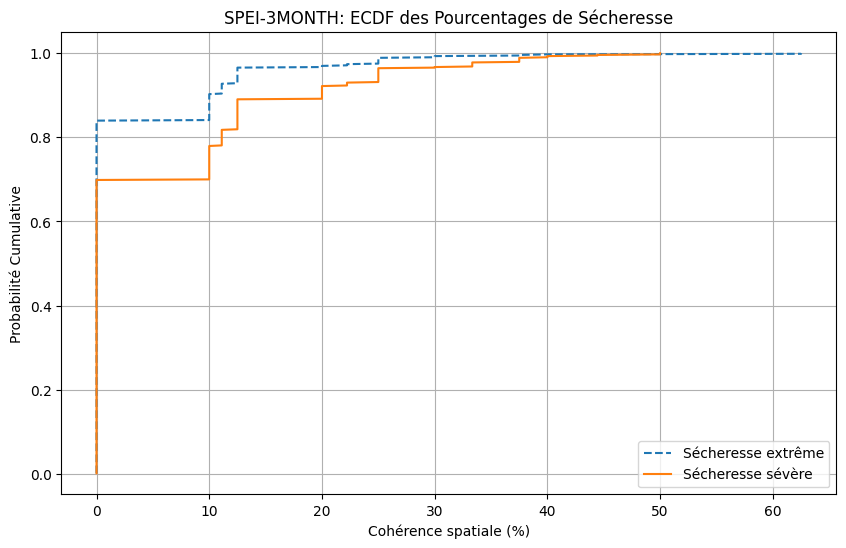

In [75]:
plot_ecdf(spei_3mois_spatial,'SPEI-3MONTH')

#### III.4- Label des secheresses

In [76]:
spei_3mois_saison=transposition_data(spei_3mois_categorized,'Label Secheresse')

In [77]:
spei_3mois_saison['Date'] = pd.to_datetime(spei_3mois_saison['Date'], format='%Y%m')
saison_pluie_mois['Date'] = pd.to_datetime(saison_pluie_mois['Date'], format='%Y%m')

spei_3mois_fusion = pd.merge(spei_3mois_saison, saison_pluie_mois, on=['Date', 'Station'], how='outer')
spei_3mois_fusion=spei_3mois_fusion[['Station','Date','Label Secheresse','Saison_Pluie','Year','Month']]
spei_3mois_fusion[['Year', 'Month']] = spei_3mois_fusion[['Year', 'Month']].applymap(to_numeric_with_nan)


##### III.4.a- Secheresse extreme

In [78]:
spei_3mois_extreme = replace_text_with_one(spei_3mois_fusion,  Constant.LABEL_7)

In [79]:
spei_3mois_extreme.to_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.DATA_3MON_EXTR),index=False)

In [80]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_3mois_extreme, 1992, 'Bobo_Dioulasso')

In [81]:
filtered_Bobo_1992.head()

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
370,Bobo_Dioulasso,1992-01-01,0,False,1992,1
371,Bobo_Dioulasso,1992-02-01,0,False,1992,2
372,Bobo_Dioulasso,1992-03-01,0,False,1992,3
373,Bobo_Dioulasso,1992-04-01,0,True,1992,4
374,Bobo_Dioulasso,1992-05-01,0,True,1992,5


#### Zoom sur la secheresse extreme

In [82]:
#process_and_plot_data(spei_3mois,'M',Constant.SEUIL_4)

##### III.4.b- Secheresse severe

In [83]:
spei_3mois_severe = replace_text_with_one(spei_3mois_fusion, Constant.LABEL_6)

In [84]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_3mois_severe, 1992, 'Bobo_Dioulasso')

In [85]:
filtered_Bobo_1992.head()

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
370,Bobo_Dioulasso,1992-01-01,0,False,1992,1
371,Bobo_Dioulasso,1992-02-01,0,False,1992,2
372,Bobo_Dioulasso,1992-03-01,0,False,1992,3
373,Bobo_Dioulasso,1992-04-01,0,True,1992,4
374,Bobo_Dioulasso,1992-05-01,0,True,1992,5


In [86]:
spei_3mois_severe.to_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.DATA_3MON_SEV),index=False)

#### Zoom sur la secheresse severe

In [87]:
#process_and_plot_data(spei_1dek,'D',-1.5,-2)
#process_and_plot_data(spei_3mois, 'M', Constant.SEUIL_2,Constant.SEUIL_3)

#### Zoom sur la secheresse modérée

In [88]:
#process_and_plot_data(spei_3mois, 'M', Constant.SEUIL_1)

### IV-SPEI SEMESTRIEL

#### IV.1- Lecture des données de spei semestriel

In [89]:
# Lire les données de SPEI mensuelles obtenu par CDT
spei_6mois=pd.read_csv(str(Config.SPEI_PATH) + '/' + str(Config.SPEI_6MON_FILE_NAME),encoding='ISO-8859-1')
# Remplacer les valeurs manquantes (-9999) par NaN pour le tracé correct
spei_6mois = spei_6mois.replace(-9999, float('nan'))
spei_6mois_categorized = categorize_drought(spei_6mois)

In [90]:
spei_6mois.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dori,Dedougou,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196106,-0.676675,NaN,-2.400092,-0.384878,-0.436150,-1.134914,0.006219,-0.567396,-1.467319,NaN
1,196107,0.419337,NaN,-1.943851,0.408821,0.268276,0.887303,-0.163733,-0.504510,0.165999,NaN
2,196108,1.044320,NaN,-1.697859,0.728468,1.623818,1.489897,0.282986,-0.110845,1.014161,NaN
3,196109,1.283650,NaN,-1.440315,0.701549,1.609807,1.529161,0.039373,0.459258,0.966873,NaN
4,196110,0.914546,NaN,-1.689736,0.416313,1.513532,1.283111,-0.589076,0.206602,0.599975,NaN


In [91]:
spei_6mois_categorized.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dori,Dedougou,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196106,Normale,NaN,Sécheresse extrême,Normale,Normale,Sécheresse modérée,Normale,Normale,Sécheresse modérée,NaN
1,196107,Normale,NaN,Sécheresse sévère,Normale,Normale,Normale,Normale,Normale,Normale,NaN
2,196108,Humidité modérée,NaN,Sécheresse sévère,Normale,Humidité sévère,Humidité modérée,Normale,Normale,Humidité modérée,NaN
3,196109,Humidité modérée,NaN,Sécheresse modérée,Normale,Humidité sévère,Humidité sévère,Normale,Normale,Normale,NaN
4,196110,Normale,NaN,Sécheresse sévère,Normale,Humidité sévère,Humidité modérée,Normale,Normale,Normale,NaN


#### IV.2 - Graphes pour le SPEI semestriel

In [92]:
# Utilisation de la fonction avec votre DataFrame spei_1mois
#plot_spei_for_stations(spei_6mois, freq='M')

#### IV.3- Secheresse spatiale

##### IV.3.a - Calcul secheresse spatiale

In [93]:
spei_6mois_spatial = calculate_secheresse_percentage(spei_6mois_categorized, Constant.LABEL_7, Constant.LABEL_6)
# Affichage de la DataFrame mise à jour
spei_6mois_spatial.head()

,Date,Pourcentage Sécheresse extrême,Pourcentage Sécheresse sévère
0,196106,12.5,0.0
1,196107,0.0,12.5
2,196108,0.0,12.5
3,196109,0.0,0.0
4,196110,0.0,12.5


In [94]:
#spei_1mois_spatial.to_csv('../DATA/spei_1mois_spatial.xlsx')

##### IV.3.b - Visualisation secheresse spatiale

In [95]:
#plot_drought_percentages(spei_6mois_spatial,'SPEI-6MONTH')

In [96]:
# Trouvez l'indice de la ligne avec la valeur maximale dans 'Pourcentage Sécheresse extrême'
indice_ligne_max_secheresse_extreme = spei_6mois_spatial[f'Pourcentage {Constant.LABEL_7}'].idxmax()
# Obtenez la ligne correspondante à cet indice
ligne_max_secheresse_extreme = spei_6mois_spatial.loc[indice_ligne_max_secheresse_extreme]
# Maintenant, ligne_max_secheresse_extreme contient la ligne avec la plus haute valeur dans 'Pourcentage Sécheresse extrême'
print(ligne_max_secheresse_extreme)

Date                              196203.0
Pourcentage Sécheresse extrême        75.0
Pourcentage Sécheresse sévère         12.5
Name: 9, dtype: float64


In [97]:
#plot_ecdf(spei_3mois_spatial,'SPEI-6MONTH')

In [98]:
#spei_6mois_spatial.to_csv('./spatial_6mois.csv')

#### IV.4- Label des secheresses

In [99]:
spei_6mois_saison=transposition_data(spei_6mois_categorized,'Label Secheresse')

In [100]:
spei_6mois_saison['Date'] = pd.to_datetime(spei_6mois_saison['Date'], format='%Y%m')
saison_pluie_mois['Date'] = pd.to_datetime(saison_pluie_mois['Date'], format='%Y%m')

spei_6mois_fusion = pd.merge(spei_6mois_saison, saison_pluie_mois, on=['Date', 'Station'], how='outer')
spei_6mois_fusion=spei_6mois_fusion[['Station','Date','Label Secheresse','Saison_Pluie','Year','Month']]
spei_6mois_fusion[['Year', 'Month']] = spei_6mois_fusion[['Year', 'Month']].applymap(to_numeric_with_nan)


In [101]:
spei_6mois_fusion.head()

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
0,Bobo_Dioulasso,1961-06-01,Normale,True,1961,6
1,Bobo_Dioulasso,1961-07-01,Normale,True,1961,7
2,Bobo_Dioulasso,1961-08-01,Humidité modérée,True,1961,8
3,Bobo_Dioulasso,1961-09-01,Humidité modérée,True,1961,9
4,Bobo_Dioulasso,1961-10-01,Normale,False,1961,10


##### IV.4.a- Secheresse extreme

In [102]:
spei_6mois_extreme = replace_text_with_one(spei_6mois_fusion,  Constant.LABEL_7)

In [103]:
spei_6mois_extreme.to_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.DATA_6MON_EXTR),index=False)

In [104]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_6mois_extreme, 1992, 'Bobo_Dioulasso')

In [105]:
filtered_Bobo_1992.head()

,Station,Date,Label Secheresse,Saison_Pluie,Year,Month
367,Bobo_Dioulasso,1992-01-01,0,False,1992,1
368,Bobo_Dioulasso,1992-02-01,0,False,1992,2
369,Bobo_Dioulasso,1992-03-01,0,False,1992,3
370,Bobo_Dioulasso,1992-04-01,0,True,1992,4
371,Bobo_Dioulasso,1992-05-01,0,True,1992,5


#### Zoom sur la secheresse extreme

In [106]:
#process_and_plot_data(spei_6mois,'M',Constant.SEUIL_4)

##### IV.4.b- Secheresse severe

In [107]:
spei_6mois_severe = replace_text_with_one(spei_6mois_fusion, Constant.LABEL_6)

In [108]:
filtered_Bobo_1992 = filter_data_by_year_station(spei_6mois_severe, 1992, 'Bobo-Dioulasso')

In [109]:
spei_6mois_severe.to_csv(str(Config.FILES_TRAITED_PATH) + '/' + str(Config.DATA_6MON_SEV),index=False)

#### Zoom sur la secheresse severe

In [110]:
#process_and_plot_data(spei_6mois, 'M', Constant.SEUIL_2,Constant.SEUIL_3)

#### Zoom sur la secheresse modérée

In [111]:
#process_and_plot_data(spei_6mois, 'M', Constant.SEUIL_1)

In [112]:
spei_6mois_categorized.head()

,Date,Bobo_Dioulasso,Bogande,Boromo,Dori,Dedougou,Fada_Ngourma,Gaoua,Ouagadougou_aero,Ouahigouya,Po
0,196106,Normale,NaN,Sécheresse extrême,Normale,Normale,Sécheresse modérée,Normale,Normale,Sécheresse modérée,NaN
1,196107,Normale,NaN,Sécheresse sévère,Normale,Normale,Normale,Normale,Normale,Normale,NaN
2,196108,Humidité modérée,NaN,Sécheresse sévère,Normale,Humidité sévère,Humidité modérée,Normale,Normale,Humidité modérée,NaN
3,196109,Humidité modérée,NaN,Sécheresse modérée,Normale,Humidité sévère,Humidité sévère,Normale,Normale,Normale,NaN
4,196110,Normale,NaN,Sécheresse sévère,Normale,Humidité sévère,Humidité modérée,Normale,Normale,Normale,NaN


In [113]:
#process_and_plot_data(spei_6mois, 'M', Constant.SEUIL_1)